In [2]:
import numpy as np
import sys, os
sys.path.append(os.pardir)
from dataset.dataset import load_mnist

## 4.2 损失函数

In [3]:
# 均方误差【4.2.1】
# def mean_squared_error(y, t):
#   return 0.5 * np.sum((y -t) ** 2)

In [4]:
# 交叉熵误差【4.2.1】
# def cross_entropy_error(y, t):
#     delta = 1e-7
#     return -np.sum(t * np.log(y + delta))

In [5]:
# 导入数据集
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [6]:
# 形状
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [7]:
# 随机选择10个数据
train_size = x_train.shape[0]
batch_size = 10
# 从train_size中选择batch_size个数据出来，返回下标
batch_mask = np.random.choice(train_size, batch_size)
# 取出训练集和对应的标签
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [8]:
# 可以同时处理单个数据和批量数据（数据作为batch集中输入）两种情况的交叉熵函数
def cross_entropy_loss(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = t.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [9]:
# 非one-hot表示的交叉熵函数
# def cross_entropy_loss(y, t):
#     if y.ndim == 1:
#         t = t.reshape(1, t.size)
#         y = y.reshape(1, y.size)
#     batch_size = t.shape[0]
#     return -np.sum(np.log(y[np.arange(batch_size)] + 1e-7)) / batch_size

## 4.3 数值微分

In [10]:
# 不好的实现示例
# def numerical_diff(f, x):
#     h = 10e-50
#     return (f(x+h) - f(x)) / h

# 中心差分
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2 * h)

In [11]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

In [12]:
import matplotlib.pylab as plt

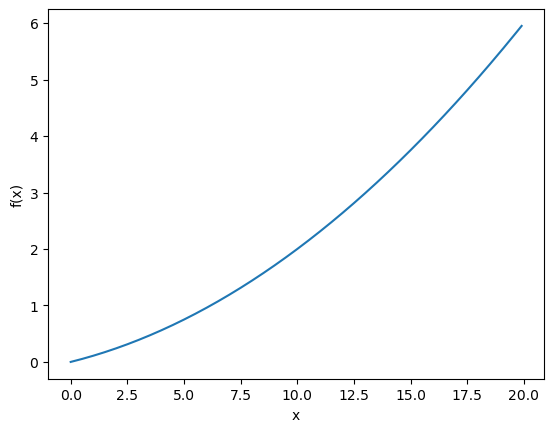

In [13]:
x = np.arange(0.0, 20.0, 0.1) # 以0.1为单位，从0到20的数组x
y = function_1(x)

plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [14]:
numerical_diff(function_1, 5)

0.1999999999990898

In [15]:
numerical_diff(function_1, 10)

0.2999999999986347

In [16]:
def function_2(x):
    return x[0]**2 + x[1]**2

## 4.4 梯度

In [17]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # 与x形状相同的数组
    
    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h)的计算
        x[idx] = tmp_val + h
        fxh1 = f(x)
        # f(x-h)的计算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad        

In [18]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

### 4.4.1 梯度法

In [19]:
# 梯度下降
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [20]:
# 使用梯度法求x0^2+x1^2的最小值
init_x = np.array([3.0, 4.0])

In [21]:
# 学习率刚好
gradient_descent(function_2, init_x,lr=0.1)

array([6.11110793e-10, 8.14814391e-10])

In [22]:
# 学习率过高
gradient_descent(function_2, init_x,lr=10)

array([-2.34235971e+12, -3.96091057e+12])

In [23]:
# 学习率过低
gradient_descent(function_2, init_x,lr=1e-10)

array([-2.34235971e+12, -3.96091057e+12])

### 4.4.2 神经网络的梯度

In [24]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

In [25]:
class simpleNet:
    def __init__(self):
        # 高斯分布初始化
        self.W = np.random.randn(2, 3)
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

In [26]:
net = simpleNet()
print(net.W)

[[ 1.32428049 -0.27022341  0.03552217]
 [-0.26229309 -0.98163866  0.13657049]]


In [27]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[ 0.55850451 -1.04560884  0.14422674]


In [28]:
t = np.array([0, 0, 1])

In [29]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.32225395  0.06479488 -0.38704882]
 [ 0.48338092  0.09719232 -0.58057324]]


## 4.5 学习算法的实现

### 4.5.1 2层神经网络的类

In [30]:
from common.functions import *
from common.gradient import numerical_gradient

In [33]:
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size,
                weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda w: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

In [35]:
# 这里来看一个例子
net = TwoLayerNet(input_size=784, hidden_size=100,output_size=10)

In [37]:
net.params['W1'].shape

(784, 100)

In [38]:
net.params['b1'].shape

(100,)

In [39]:
net.params['W2'].shape

(100, 10)

In [40]:
net.params['b2'].shape

(10,)

In [41]:
x = np.random.rand(100, 784)
y = net.predict(x) # 接近均匀分布。

In [45]:
x = np.random.rand(100, 784) # 伪输入数据
t = np.random.rand(100, 10) # 伪正确解标签

# ! 这一步耗时较长
grads = net.numerical_gradient(x, t)

(784, 100)

In [47]:
print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


### 4.5.2. mini-batch

In [50]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# 超参数
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # get mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # cal the gradient
    grad = network.numerical_gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

KeyboardInterrupt: 

### 4.5.3 基于测试数据的评价

In [31]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []
# 平均每个epoch的重复次数
iter_per_epoch = max(train_size / batch_size, 1)

# 超参数
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # get mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # cal the gradient
    grad = network.numerical_gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
#     计算每个epoch的识别精度
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train_acc, test_acc " + str(train_acc) + "," + str(test_acc))
